<a href="https://colab.research.google.com/github/aguilin1/tda_ai_text_generation/blob/main/tda_ai_text_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!git clone https://github.com/aguilin1/tda_ai_text_generation.git
!pip install nltk
!pip install Ripser

Cloning into 'tda_ai_text_generation'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 140 (delta 6), reused 0 (delta 0), pack-reused 123 (from 2)
Receiving objects: 100% (140/140), 7.20 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (62/62), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00
  Created wheel for hopcroftkarp: filename=hopcroftkarp-1.2.5-py2.py3-none-any.whl size=18104 sha256=d4d2dac5fa49c9183aa693e179c30387219aa9510bbdddb666bd0338f06429b1
  Stored in directory: /root/.cache/pip/wheels/1f/cc/2d/de23a8b9ae586817b0b44de4a4b1a08f23473e248a644b312f
Successfully built hopcroftkarp


In [4]:
# set up Ripser for use (run this just once)

from ripser import ripser, Rips
from persim import plot_diagrams

In [27]:
# Functions ---
# cosSimDistanceMatrix: creates cosine similarity distance matrix
# vrFiltration: takes a distance matrix and computes Vietoris-Rips filtration

from sklearn.metrics.pairwise import cosine_similarity
import itertools
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def smoothing(embeddings):
  number_sentences = embeddings.shape[0]
  original_embeddings = embeddings.copy()
  for i in range(number_sentences):
    smoothed = original_embeddings[(i -3)%number_sentences]/8.0 + original_embeddings[(i -2)%number_sentences]/4.0 + original_embeddings[(i -1)%number_sentences]/2.0 + original_embeddings[i] + original_embeddings[(i +1)%number_sentences]/2.0 + original_embeddings[(i +2)%number_sentences]/4.0 + original_embeddings[(i +3)%number_sentences]/8.0
    embeddings[i] = smoothed
  return embeddings


def angular_distance(embeddings, index_1, index_2):
  cos_sim = cosine_similarity(embeddings[index_1].reshape(1, -1),\
                              embeddings[index_2].reshape(1, -1))[0][0]

  dist = 2 * np.arccos(cos_sim) / np.pi
  return dist

# input a single array of embeddings
def angular_distance_matrix(embeddings, time_skeleton = False):
  # get # of data points in each sample
  n_dpts = embeddings.shape[0]
  # preallocate distance matrix
  angular_distances = np.zeros((n_dpts, n_dpts))
  # Label each data point in order starting at 0, 1, 2, ...
  # Distance between data point i and data point j is in (i,j) entry of matrix
  # Matrix will be upper triangular
  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      dist = angular_distance(embeddings, pair1_i, pair2_i)
    angular_distances[pair1_i][pair2_i] = dist
    angular_distances[pair2_i][pair1_i] = dist
  return angular_distances


def mixed_distance_matrix(bow_embeddings, bert_embeddings, alpha, time_skeleton = False):
  # This should align with the tokens (number of sentences), so match between types
  n_dpts = bert_embeddings.shape[0]

  cosSimDistances = np.zeros((n_dpts, n_dpts))

  for pair1_i, pair2_i in itertools.combinations(range(n_dpts), 2):
    if time_skeleton and (pair1_i == pair2_i + 1 or pair1_i == pair2_i - 1):
      dist = 0
    else:
      distance_bow = angular_distance(bow_embeddings, pair1_i, pair2_i)
      distance_bert = angular_distance(bert_embeddings, pair1_i, pair2_i)
      dist = alpha * distance_bow + (1 - alpha) * distance_bert

    cosSimDistances[pair1_i][pair2_i] = dist
    cosSimDistances[pair2_i][pair1_i] = dist
  return cosSimDistances

# input a symmetric distance matrix and this function will return birth and
# death homology data for the V-R complex
def ripserFiltration(distanceMat, maxDim=2):
  # Here's one way to use Ripser
  # examples and instructions are here:
  # https://ripser.scikit-tda.org/en/latest/notebooks/Basic%20Usage.html
  # https://docs.scikit-tda.org/en/latest/notebooks/scikit-tda%20Tutorial.html#1.1.3.-Input-option:-Distance-matrix

  # This version uses the distance matrix input, which is what we want
  birthDeathPairs = ripser(distanceMat, distance_matrix=True, maxdim=maxDim)['dgms']

  # diagrams is a vector of vectors where each element of each
  # vector is [birth epoch, death epoch] and the vectors are in increasing order
  # of homology (H0, H1, H2, etc.).
  return birthDeathPairs

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


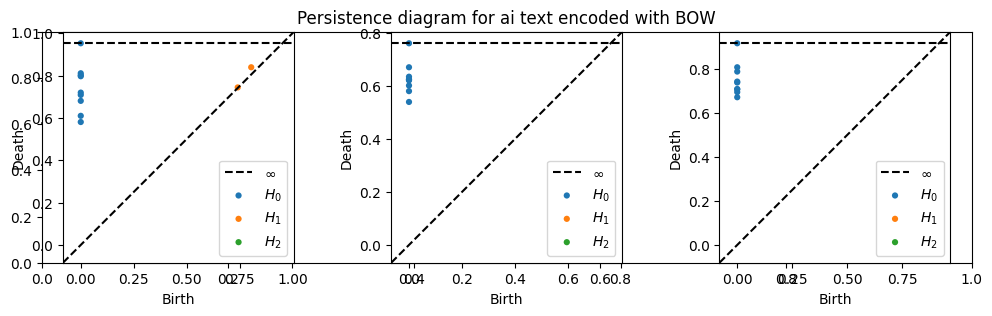

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


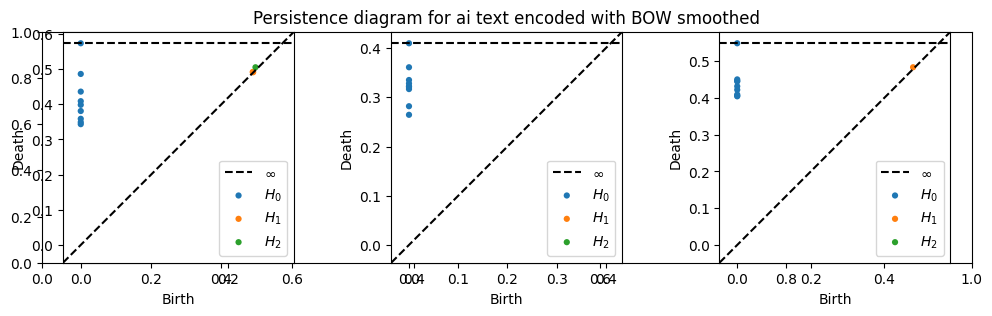

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


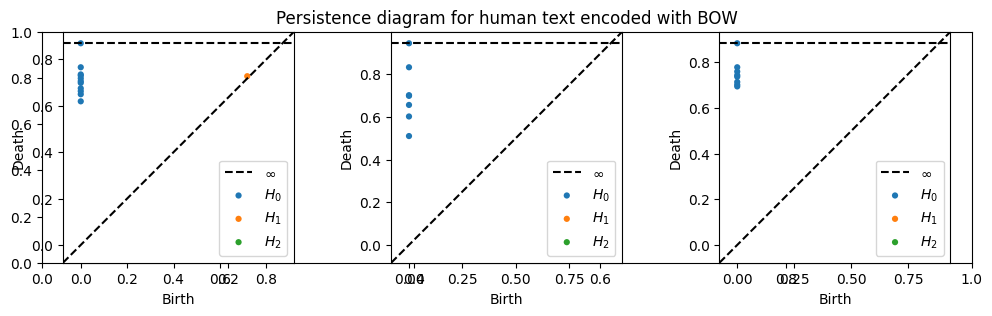

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


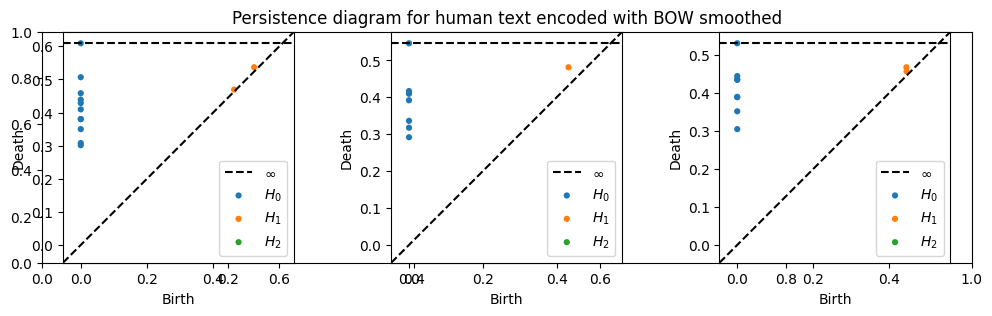

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


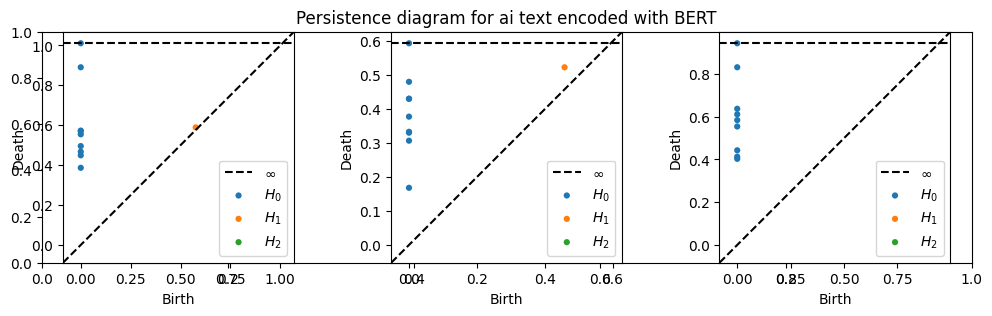

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


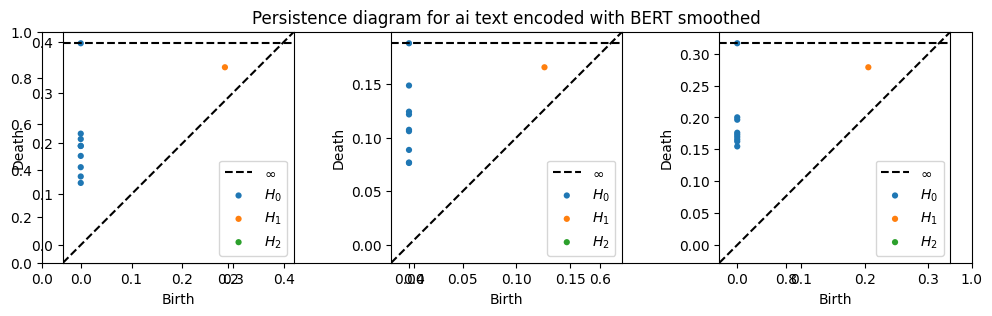

In [30]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ripser import Rips
from persim import PersImage
from persim import PersistenceImager

def load_cached_embeddings(abstract_type, embedding_type):
  DATA_FILE_BASE = '/content/tda_ai_text_generation/data/{}_encodings_{}-{}.pkl'

  bert_data = DATA_FILE_BASE.format('sentence-bert', abstract_type, 1)
  bow_data = DATA_FILE_BASE.format('bow', abstract_type, 0)


  if embedding_type == 'bert':
    with open(bert_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  elif embedding_type == 'bow':
    with open(bow_data, "rb") as data_file:
        cache_data = pickle.load(data_file)
        batch_sentences = cache_data['sentences']
        batch_embeddings = cache_data['embeddings']
  return batch_sentences, batch_embeddings


def run_evaluation(abstract_type, embedding_type, time_skeleton = False, with_smoothing = False):
  _, batch_embeddings = load_cached_embeddings(abstract_type, embedding_type)

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,3))
  title = "Persistence diagram for {} text encoded with {}".format(abstract_type, embedding_type.upper())
  if time_skeleton:
    title += " with time skeleton"
  if with_smoothing:
    title += " smoothed"
  plt.title(title)
  subplot = 1
  for i, embeddings in enumerate(batch_embeddings[0:3]):
    if with_smoothing:
      embeddings = smoothing(embeddings)
    distances = angular_distance_matrix(embeddings, time_skeleton)
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(1,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()


def run_mixed_encoding_evaluation(abstract_type, alpha, n, time_skeleton = False):
  _, batch_bow_embeddings = load_cached_embeddings(abstract_type, 'bow')
  _, batch_bert_embeddings = load_cached_embeddings(abstract_type, 'bert')
  if alpha < 0.0 and alpha > 1.0:
    raise ValueError("alpha must be between 0 and 1")

  rips = Rips()
  bert_diagrams = []
  plt.figure(figsize=(12,3))
  title = "Persistence diagrams for {} mixed encoding with alpha={}".format(abstract_type, alpha)
  if time_skeleton:
    title += " with time skeleton"
  plt.title(title)
  subplot = 1
  for i in range(n):
    distances = mixed_distance_matrix(batch_bow_embeddings[i], batch_bert_embeddings[i], alpha, time_skeleton)
    diagram = ripserFiltration(distances)
    bert_diagrams.append(diagram)

    plt.subplot(1,3,subplot)
    subplot += 1
    rips.plot(diagram, show=False)


  plt.show()
  return distances

run_evaluation('ai', 'bow')
run_evaluation('ai', 'bow', with_smoothing=True)
# run_evaluation('ai', 'bow', True)
run_evaluation('human', 'bow')
run_evaluation('human', 'bow', with_smoothing=True)
# run_evaluation('human', 'bow', True)

run_evaluation('ai', 'bert')
run_evaluation('ai', 'bert', with_smoothing=True)
# run_evaluation('human', 'bert')

# run_mixed_encoding_evaluation('ai', 0.5, 3, True)
# run_mixed_encoding_evaluation('ai', 0.5, 3)
# run_mixed_encoding_evaluation('human', 0.5, 3, True)
# run_mixed_encoding_evaluation('human', 0.5, 3)

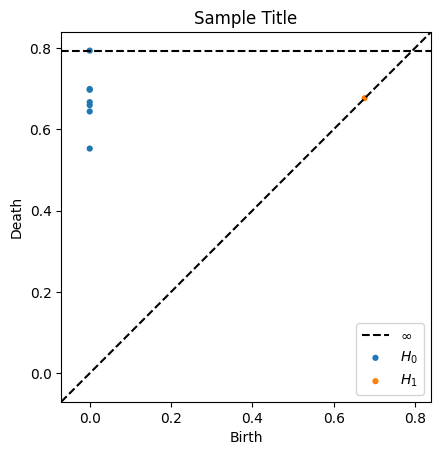

[[6.31720853e-07 6.25470564e-07 6.13125262e-07 5.95048300e-07
  5.71762805e-07 5.43926544e-07 5.12301090e-07 4.77717310e-07
  4.41039359e-07 4.03129325e-07]
 [6.69130892e-07 6.62510465e-07 6.49434084e-07 6.30286617e-07
  6.05622173e-07 5.76137469e-07 5.42639179e-07 5.06007373e-07
  4.67157382e-07 4.27002343e-07]
 [7.01709927e-07 6.94767161e-07 6.81054109e-07 6.60974380e-07
  6.35109058e-07 6.04188786e-07 5.69059511e-07 5.30644155e-07
  4.89902613e-07 4.47792482e-07]
 [7.28559177e-07 7.21350763e-07 7.07113014e-07 6.86264982e-07
  6.59409985e-07 6.27306623e-07 5.90833211e-07 5.50947984e-07
  5.08647564e-07 4.64926190e-07]
 [7.48915327e-07 7.41505507e-07 7.26869952e-07 7.05439419e-07
  6.77834087e-07 6.44833748e-07 6.07341258e-07 5.66341626e-07
  5.22859320e-07 4.77916359e-07]
 [7.62186544e-07 7.54645418e-07 7.39750512e-07 7.17940218e-07
  6.89845703e-07 6.56260579e-07 6.18103700e-07 5.76377531e-07
  5.32124693e-07 4.86385316e-07]
 [7.67981059e-07 7.60382601e-07 7.45374457e-07 7.23398350e

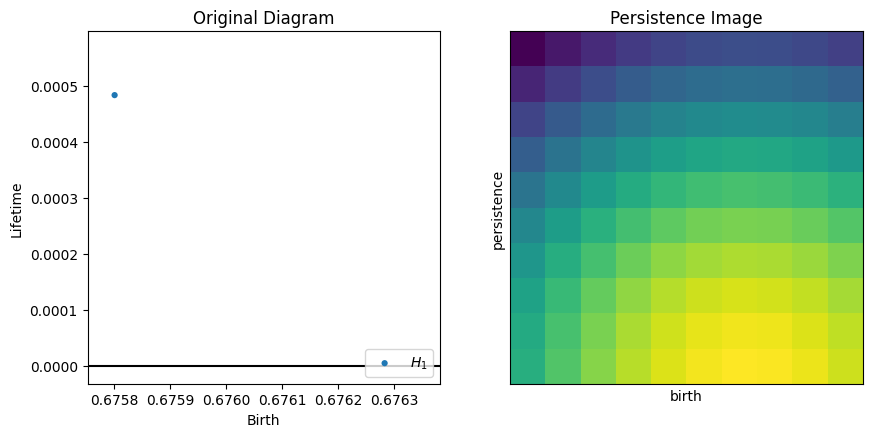

In [ ]:
import ripser
import persim

D = tempOutput
persistenceDiagrams = ripser.ripser(D, distance_matrix=True)['dgms']
persim.plot_diagrams(
    persistenceDiagrams, show=True,
    title=f"Sample Title"
)

from persim import PersistenceImager

# how to set this pixel size correctly?
pimager = PersistenceImager(pixel_size=0.1)

# The `transform()` method can then be called on one or more (*,2) numpy arrays to generate persistence images from diagrams.
persistenceImgs = pimager.transform(persistenceDiagrams[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].set_title("Original Diagram")
persim.plot_diagrams(persistenceDiagrams[1:3], lifetime=True, ax=axs[0], labels=["$H_1$", "$H_2$"])
axs[1].set_title("Persistence Image")
pimager.plot_image(persistenceImgs[0], ax=axs[1])
print(persistanceImgs[0])
print(persistenceImgs[0].shape)

0


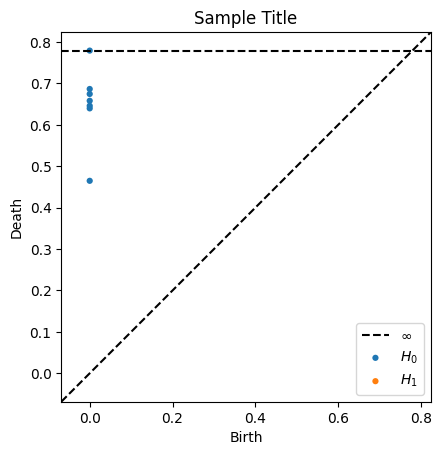

ValueError: zero-size array to reduction operation minimum which has no identity

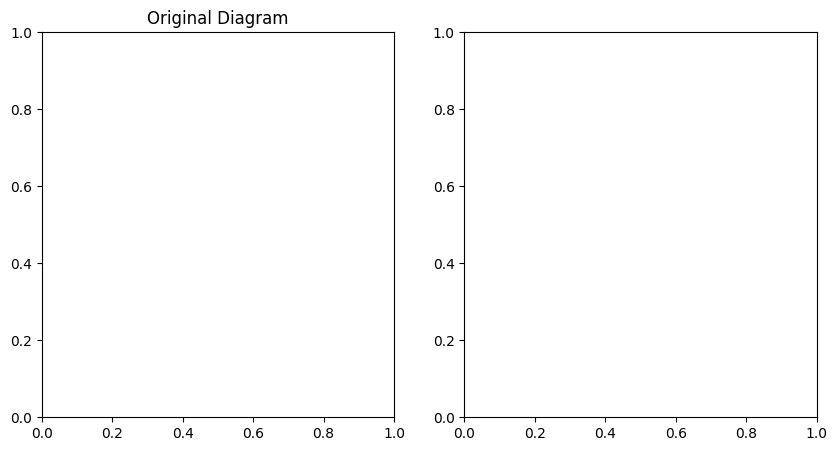

In [ ]:
import ripser
import persim

D2 = tempOutput2
persistenceDiagrams2 = ripser.ripser(D2, distance_matrix=True)['dgms']
print(len(persistenceDiagrams2[1]))
persim.plot_diagrams(
    persistenceDiagrams2, show=True,
    title=f"Sample Title"
)

from persim import PersistenceImager

# how to set this pixel size correctly?
pimager2 = PersistenceImager(pixel_size=0.1)

# The `transform()` method can then be called on one or more (*,2) numpy arrays to generate persistence images from diagrams.
persistenceImgs2 = pimager2.transform(persistenceDiagrams2[1:3])

fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].set_title("Original Diagram")
persim.plot_diagrams(persistenceDiagrams2[1:3], lifetime=True, ax=axs[0], labels=["$H_1$", "$H_2$"])
axs[1].set_title("Persistence Image")
pimager2.plot_image(persistenceImgs2[0], ax=axs[1])
print(persistanceImgs2[0])
print(persistenceImgs2[0].shape)

In [ ]:
## To wrap the array outputs for readability
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
# Gather 3 sets: human cases, AI cases, and test ("unknown") cases

# Determine a representative persistence diagram for human cases and AI cases? HOW?

# Compare each of the test cases against the representative diagrams, classify,
# and determine whether classification was successful or not

# suggest using
# https://persim.scikit-tda.org/en/latest/notebooks/distances.html

# Example
# if A and B are two Ripser persistence diagrams to be compared
#distance = persim.bottleneck(A, B, matching=False)
# and then just see whether the test case distance from human diagram is smaller
# or larger than distance from AI diagram. Classify based on smaller distance